# 比特映射

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/zh_cn/mindspore_qubit_mapping.ipynb)&emsp;
[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/zh_cn/mindspore_qubit_mapping.py)&emsp;
[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindquantum/docs/source_zh_cn/qubit_mapping.ipynb)

用户在设计量子线路时往往是根据自己的算法需求来进行设计，但是现阶段的量子芯片难以实现所有比特之间都有耦合。因此，在量子计算硬件上执行量子线路时，我们需要通过一定的算法来将量子算法中所用到的比特进行重新排列，或者引入一些 [SWAP](https://mindspore.cn/mindquantum/docs/zh-CN/master/mindquantum.core.gates.html#%E9%A2%84%E5%AE%9E%E4%BE%8B%E5%8C%96%E9%97%A8) 门，来将本来不能耦合的比特耦合起来。这也就是比特映射算法。

在这篇教程中，我们将首先介绍构成量子芯片中的量子节点对象 [QubitNode](https://mindspore.cn/mindquantum/docs/zh-CN/master/mindquantum.device.QubitNode.html#mindquantum.device.QubitNode) 和量子拓扑图对象 [QubitsTopology](https://mindspore.cn/mindquantum/docs/zh-CN/master/mindquantum.device.QubitsTopology.html#mindquantum.device.QubitsTopology)，然后将介绍如何利用比特映射算法来实现量子线路的编译。

## Qubit Node

[QubitNode](https://mindspore.cn/mindquantum/docs/zh-CN/master/mindquantum.device.QubitNode.html#mindquantum.device.QubitNode)表示量子芯片中的比特，当前，主要包含四个属性：

- qubit_id：量子比特的唯一识别码
- color：在绘制拓扑结构图时，量子比特的颜色， 默认为 #000000
- poi_x：在绘制拓扑结构图时，量子比特的 x 位置，默认为 0.0
- poi_y：在绘制拓扑结构图时，量子比特的 y 位置，默认为 0.0

下面，我们申明一个量子比特：

In [1]:
from mindquantum.device import QubitNode

q0 = QubitNode(0, '#121212', 0, 0)

print(f"qubit id: {q0.qubit_id}, with color: {q0.color}, and position ({q0.poi_x}, {q0.poi_y})")

qubit id: 0, with color: #121212, and position (0, 0)


量子比特之间可以通过运算符 `>>` 和 `<<` 来将两个比特连接起来，也可以同过 `>` 和 `<` 取消连接。不同方向的连接或者取消连接算符会有不同的返回值。

|lhs|op|rhs|效果|返回值|
| --|--|-- |-- |--|
|q0 |`>>`|q1 |连接两个比特|q1|
|q0 |`<<`|q1 |连接两个比特|q0|
|q0 |`>`|q1 |取消连接两个比特|q1|
|q0 |`<`|q1 |取消连接两个比特|q0|

通过如上定义的操作，我们可以快速连接不同的比特，如：

In [2]:
q0, q1, q2 = QubitNode(0), QubitNode(1), QubitNode(2)

q0 >> q1 >> q2

在上述代码中 `q0 >> q1` 会将 `q0` 和 `q1` 比特连接起来，并返回 `q1` 比特，而后再通过 `>> q2` 就可以将 `q1` 和 `q2` 连接起来。

### QubitsTopology

[QubitsTopology](https://mindspore.cn/mindquantum/docs/zh-CN/master/mindquantum.device.QubitsTopology.html#mindquantum.device.QubitsTopology) 类是量子比特的容器，可以有效地组织和操控量子比特，例如当我们想要构建一个一维链的量子比特时，我们可以如下操作：

In [3]:
from mindquantum.device import QubitsTopology, QubitNode

n = 5

topology = QubitsTopology([QubitNode(i, poi_x=i) for i in range(n)])
print(topology)

MindQuantum 中自带了绘制量子比特拓扑结构图的接口，接口如下：

In [4]:
from mindquantum.io.display import draw_topology

draw_topology(topology)

由上我们可以发现，我们成功产生了 5 个量子比特，但是还没有将其连接起来，下面我们就来将其进行耦合。

In [5]:
left_node = topology[0]
for i in range(1, n):
    left_node = left_node << topology[i]

draw_topology(topology)

在上述代码中，我们通过取值运算符 `[]`，获取对应 qubit_id 的量子比特，然后我们利用 `<<` 运算符进行比特之间的连接。

在 MindQuantum 中，我们已经集成了多种结构，如这里提到的[一维链结构](https://mindspore.cn/mindquantum/docs/zh-CN/master/mindquantum.device.LinearQubits.html#mindquantum.device.LinearQubits)，和[方格子结构](https://mindspore.cn/mindquantum/docs/zh-CN/master/mindquantum.device.GridQubits.html)：

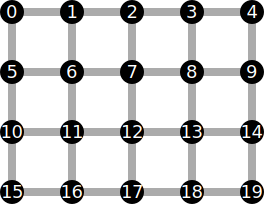

In [6]:
from mindquantum.device import LinearQubits, GridQubits
from IPython.display import display_svg

t1 = LinearQubits(3)
t2 = GridQubits(4, 5)

display_svg(draw_topology(t1))
display_svg(draw_topology(t2))

我们还可以对拓扑结构图进行更多的操作，如删除某个节点：

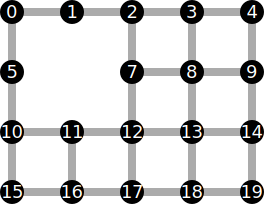

In [7]:
t2.remove_qubit_node(6)

draw_topology(t2)

孤立某个节点：

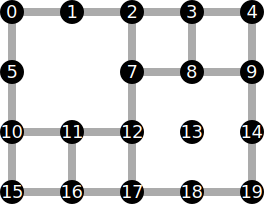

In [8]:
t2.isolate_with_near(13)

draw_topology(t2)

修改节点颜色：

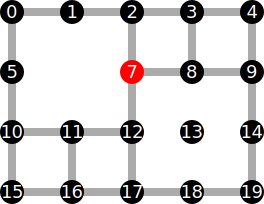

In [9]:
t2.set_color(7, '#ff0000')

draw_topology(t2)

修改节点位置：

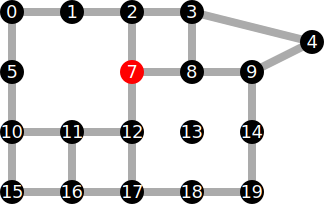

In [10]:
t2.set_position(4, 5.0, 0.5)

draw_topology(t2)

重新耦合比特：

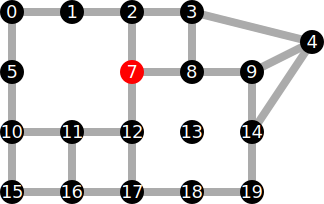

In [11]:
t2[4] << t2[14]

draw_topology(t2)

我们还可以获取拓扑结构中所有的耦合边：

In [12]:
t2.edges_with_id()

{(0, 1),
 (0, 5),
 (1, 2),
 (2, 3),
 (2, 7),
 (3, 4),
 (3, 8),
 (4, 9),
 (4, 14),
 (5, 10),
 (7, 8),
 (7, 12),
 (8, 9),
 (9, 14),
 (10, 11),
 (10, 15),
 (11, 12),
 (11, 16),
 (12, 17),
 (14, 19),
 (15, 16),
 (16, 17),
 (17, 18),
 (18, 19)}

### Qubit Mapping

当我们在真实量子硬件上运行量子线路时，我们往往不能直接运行，因为真实硬件中的比特拓扑关系和用户给定的量子线路结构并不一定匹配，这时比特映射技术就应运而生。我们可以通过对量子比特进行重新映射，或插入一下 [SWAP](https://mindspore.cn/mindquantum/docs/zh-CN/master/mindquantum.core.gates.html#%E9%A2%84%E5%AE%9E%E4%BE%8B%E5%8C%96%E9%97%A8) 门，来使得线路能够成功运行。

我们给定一个量子线路：

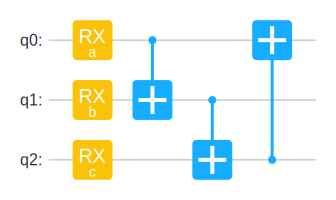

In [13]:
from mindquantum.core.circuit import Circuit

circ = Circuit().rx('a', 0).rx('b', 1).rx('c', 2).x(1, 0).x(2, 1).x(0, 2)
circ.svg()

再给定一个 2x2 的方格子量子拓扑结构：

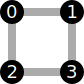

In [14]:
t = GridQubits(2, 2)

draw_topology(t)

由于上述量子线路中的量子比特两两都有相互作用，因此无法直接在上述的量子硬件中运行。我们引入 [SABER](https://mindspore.cn/mindquantum/docs/zh-CN/master/mindquantum.algorithm.mapping.SABRE.html#mindquantum.algorithm.mapping.SABRE) 算法解决该问题。更多算法细节，请参考论文：[Tackling the Qubit Mapping Problem for NISQ-Era Quantum Devices](https://arxiv.org/abs/1809.02573)

In [15]:
from mindquantum.algorithm.mapping import SABRE

solver = SABRE(circ, t)
new_circ, init_mapping, final_mapping = solver.solve(5, 0.5, 0.3, 0.2)

我们可以看到新给出的量子线路为：

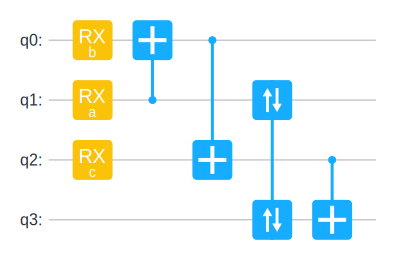

In [16]:
new_circ.svg()

通过对比旧的量子线路，我们得知，算法重新分配的比特编号，并在合适的位置加入了 [SWAP](https://mindspore.cn/mindquantum/docs/zh-CN/master/mindquantum.core.gates.html#%E9%A2%84%E5%AE%9E%E4%BE%8B%E5%8C%96%E9%97%A8) 门，使得线路得意正常运行。

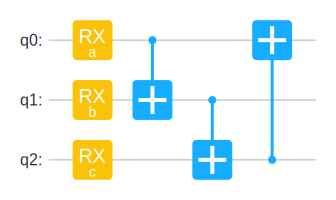

In [17]:
circ.svg()

这里 `init_mapping` 和 `final_mapping` 分别告诉我们，最开始量子线路应该如何作用在量子硬件上，以及运行完线路后，各量子比特与原始线路中量子比特的对应关系。

In [18]:
print(f"initial mapping: {init_mapping}")
print(f"  final mapping: {final_mapping}")

initial mapping: [1, 0, 2, 3]
  final mapping: [3, 0, 2, 1]


我们还可以通过 `draw_topology`，在量子拓扑图中绘制出新的量子线路用到了哪些量子比特以及其耦合的边。

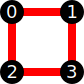

In [19]:
draw_topology(t, new_circ)

我们发现，其中的4个量子比特和4条边全部都用上了。

In [20]:
from mindquantum.utils.show_info import InfoTable
InfoTable('mindquantum', 'scipy', 'numpy')

Software,Version
mindquantum,0.9.0
scipy,1.7.3
numpy,1.21.6
System,Info
Python,3.7.10
OS,Darwin x86_64
Memory,8.59 GB
CPU Max Thread,4
Date,Wed Aug 2 16:11:10 2023
